In [1]:
# training on P100: 849MB memory, training loss decrease slow
# training on V100: 1255MB memory, training loss decrease much faster

# ref bus is 639(640)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
root=''
try:
  from google.colab import drive
  drive.mount('/content/drive')
  root='./drive/MyDrive/gnn/data/'
except:
  pass
device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Quadro RTX 5000


In [3]:
!pwd

/mnt/Data/GNN_bkup


In [4]:
filename=root+'data_1354ac_2022/ieee1354_ISF.txt'
S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
filename=root+'data_1354ac_2022/ieee1354_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit
print(S.shape,f_max.shape,torch.min(f_max))

torch.Size([1991, 1354]) torch.Size([1991, 1]) tensor(281., device='cuda:0', dtype=torch.float64)


In [5]:
# x=np.load('/content/drive/MyDrive/gnn/data/dc118_p10_x.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/dc118_p10_y.npy')
# All cases
# x=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_x.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_y.npy')
# Normal cases
x=np.load(root+'data_1354ac_2022/ac1354_x.npy')
y=np.load(root+'data_1354ac_2022/ac1354_y.npy')
# x=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/dc118_p10_x_normal1.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/dc118_p10_y_normal1.npy')
W=np.load(root+'data_1354ac_2022/ac1354_w.npy')
# W=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_w.npy')
print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))

# scaling on voltage
vy_deviation = 0.8
vy_scale = 1000
y[:,1,:] = (y[:,1,:] - vy_deviation) * vy_scale
print('voltage:',np.min(y[:,1,:]),np.max(y[:,1,:]))

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=0.2, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, device='cpu'):
        self.features=torch.from_numpy(np.transpose(features)).float().to(device)
        self.labels=torch.from_numpy(np.transpose(labels)).float().to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = torch.reshape(X,(6,1354))
        y = torch.reshape(y,(2,1354))
        return X, y
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 0}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train,device=device)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test,device=device)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)

(1354, 6, 7912) (1354, 2, 7912)
5864.5 -2178.4 107920.0 -52503.0
voltage: 85.71999999999991 334.30000000000007
Training data size: (1354, 6, 6329)
Training label size: (1354, 2, 6329)


In [6]:
# voltage range
print('voltage:',np.min(y[:,1,:]),np.max(y[:,1,:]))
print('price:',np.min(y[:,0,:]),np.max(y[:,0,:]))

voltage: 85.71999999999991 334.30000000000007
price: -52503.0 107920.0


(array([2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 3.000000e+00,
        2.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        2.000000e+00, 1.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 3.000000e+00, 4.000000e+00,
        1.000000e+00, 4.000000e+00, 5.000000e+00, 5.000000e+00,
        7.000000e+00, 9.000000e+00, 1.000000e+01, 2.200000e+01,
        2.300000e+01, 2.800000e+01, 1.780000e+02, 5.410000e+02,
        4.863105e+06, 5.845142e+06, 1.020000e+03, 6.520000e+02,
        5.480000e+02, 2.490000e+02, 1.890000e+02, 1.950000e+02,
        1.000000e+02, 9.300000e+01, 9.400000e+01, 4.900000e+01,
        8.400000e+01, 3.300000e+01, 2.300000e+01, 2.700000e+01,
        5.700000e+01, 5.300000e+01, 6.400000e+01, 5.000000e+01,
        4.600000e+01, 4.200000e+01, 2.100000e+01, 1.200000e+01,
        3.000000e+00, 6.000000e+00, 1.000000e+00, 9.000000e+00,
        4.000000e+00, 3.000000e+00, 0.00

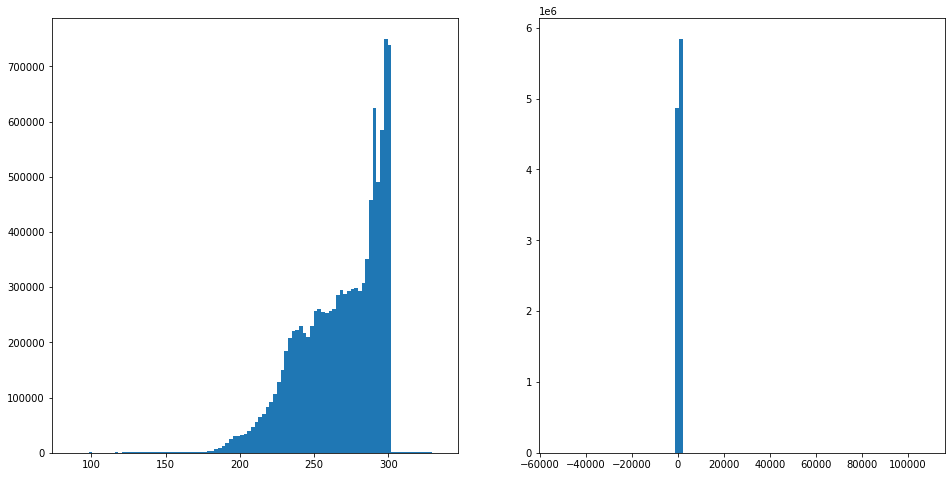

In [7]:
fig2 = plt.figure(figsize=(16, 8))
flat_list = list(np.concatenate(y[:,1,:]).flat)
flat_list3 = list(np.concatenate(y[:,0,:]).flat)
plt.subplot(1,2,1)
plt.hist(flat_list,bins = 100)
plt.subplot(1,2,2)
plt.hist(flat_list3,bins = 100)
# plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')

* Normalize the power of Laplacian

In [8]:
W1 = W.copy()
W1 = np.asarray(W1)
# print(np.asarray([[2,3],[4,7]])/5)
W1 = W1 / 1
W2 = W1.copy()
print(type(W))
lam,v = np.linalg.eig(W1)
print(lam[0])
for i in range(5):
  W1 = np.matmul(W1,W2) / np.max(np.matmul(W1,W2))
  # print(W1)
  lam,v = np.linalg.eig(W1)
  print(lam[0])#/10**(i+1))

<class 'numpy.ndarray'>
(3+0j)
(0.08181818181818182+0j)
(0.022314049586776866+0j)
(0.006085649887302784+0j)
(0.0016597226965371218+0j)
(0.00045265164451012446+0j)


In [9]:
def numparam(in_feats,out_feats): return 4*476+in_feats*out_feats+out_feats
indexes=[1,10,15,15,10,10,1]
total=0
for temp in range(len(indexes)-1):
  total+=numparam(indexes[temp],indexes[temp+1])
print(total)

12130


In [10]:
from torch.autograd import Variable
# One layer Graph convolution from nodes to edges
class Graph_convolution_v2v_W(nn.Module):
    def __init__(self,in_features,out_features,W,n,bias=True):
        super(Graph_convolution_v2v_W,self).__init__()
        self.register_buffer('w',torch.from_numpy(W.transpose()).float())
        self.register_buffer('n0',torch.tensor(n))
        self.mapping=nn.Parameter(torch.Tensor(n,W.shape[0],W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        self.scale0=nn.Parameter(torch.Tensor(out_features,in_features))
        torch.nn.init.xavier_uniform_(self.scale0.data)
        self.scale=nn.Parameter(torch.Tensor(n-1,out_features,out_features))
        torch.nn.init.xavier_uniform_(self.scale.data)
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
        torch.nn.init.xavier_uniform_(self.bias.data)

    def forward(self,input):
        h=torch.mul(self.mapping[0,:,:],self.w) # element-wise
        h=torch.matmul(input,h) # transpose due to batch generator
        h=torch.matmul(self.scale0,h)
        for i in range(self.n0 - 1):
          W1 = torch.matrix_power(self.w,i+2)/torch.max(torch.matrix_power(self.w,i+2))
          h1=torch.mul(self.mapping[i,:,:],W1)
          h=torch.matmul(h,h1) # transpose due to batch generator 
          h=torch.matmul(self.scale[i,:,:],h)
        return h+self.bias 

# GNN using DGL v2v graph convolution and our own v2e graph convolution
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, W, num_bus, n_hop):
        super(GCN, self).__init__()
        self.conv_v2v1=Graph_convolution_v2v_W(in_feats,hidden_size[0],W,n_hop)
        self.conv_v2v2=Graph_convolution_v2v_W(hidden_size[0],hidden_size[1],W,n_hop)
        self.conv_v2v3=Graph_convolution_v2v_W(hidden_size[1],hidden_size[2],W,n_hop)
        self.conv_v2v4=Graph_convolution_v2v_W(hidden_size[2],hidden_size[3],W,n_hop)
        self.conv_v2v5=Graph_convolution_v2v_W(hidden_size[3],hidden_size[4],W,n_hop)
        self.conv_v2v6=Graph_convolution_v2v_W(hidden_size[4],hidden_size[5],W,n_hop)
        # self.conv_v2v7=Graph_convolution_v2v_W(hidden_size[5],hidden_size[6],W,n_hop)
        # self.conv_v2v8=Graph_convolution_v2v_W(hidden_size[6],hidden_size[7],W,n_hop)
        self.lin_output = nn.Linear(num_bus,num_bus)
         
    def forward(self, inputs):
        # m = nn.ELU()
        # m = nn.LeakyReLU()
        # m = nn.Tanh()
        m = nn.ReLU()
        h=self.conv_v2v1(inputs)
        h=m(h)
        h=self.conv_v2v2(h)
        h=m(h)
        h=self.conv_v2v3(h)
        h=m(h)
        h=self.conv_v2v4(h)
        h=m(h)
        h=self.conv_v2v5(h)
        h=m(h)
        h=self.conv_v2v6(h)
        h=torch.relu(h)
        h = self.lin_output(h)
        # time.sleep(5)
        return h
n_bus=x.shape[0]
# w_params=[10,15,10,1]
w_params=[5,10,10,5,5,2]
n_hop = 2
# W = W / 10 # normalize
net=GCN(6,w_params,W,n_bus, n_hop) # Laplacian
net=net.to(device)

# set loss_func & optimizer

optimizer=torch.optim.Adam(net.parameters())
loss_optm=[]
loss_val=[]
print(net)
print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

GCN(
  (conv_v2v1): Graph_convolution_v2v_W()
  (conv_v2v2): Graph_convolution_v2v_W()
  (conv_v2v3): Graph_convolution_v2v_W()
  (conv_v2v4): Graph_convolution_v2v_W()
  (conv_v2v5): Graph_convolution_v2v_W()
  (conv_v2v6): Graph_convolution_v2v_W()
  (lin_output): Linear(in_features=1354, out_features=1354, bias=True)
)
number of params: 23835043


In [11]:
# Number of parameters in net
n_params = 0
n_params_trainable = 0
for temp in net.parameters():
    # print(temp.shape[0])
    # print(temp.shape)
    n_params += temp.numel()
    if abs(temp.shape[0] - n_bus) > 0:
      n_params_trainable += temp.shape[0] * temp.shape[1]
    else:
      n_params_trainable += n_bus + 2 * n_line
print('Number of GNN parameters:',n_params)
print('Number of effective GNN parameters:',n_params_trainable)

Number of GNN parameters: 23835043
Number of effective GNN parameters: 27259


In [12]:
# threshold function for p_g
class my_gen_pred_binary(nn.Module):
  def __init__(self):
    super(my_gen_pred_binary,self).__init__()
  def forward(self,x,thresh):
    # thresh=torch.tensor(thresh).double()
    # print(thresh,thresh.dtype)
    # print(x.dtype,x)
    right_thresh=torch.tensor(thresh).double()
    left_thresh=torch.tensor(0).double()
    x=x.double()


    # output=torch.where(x<left_thresh,0.,x)
    # output=torch.where(output>right_thresh,right_thresh,output)

    # 1st layer
    output = torch.sigmoid(left_thresh - x)
    output = torch.mul(output,left_thresh - x) + x
    # 2nd layer
    output = torch.sigmoid(output - right_thresh)
    output = torch.mul(output,output - right_thresh) + right_thresh

    # output=torch.where(output*output<thresh*thresh,output/thresh,output)
    return output

In [13]:
## params needed for S calculation
# line parameters
filename1 = root+'data_1354ac_2022/ieee1354_lineloc.txt'
# filename2 = 'data_1354ac_2022/ieee1354_lineparams.txt'
filename2 = root+'data_1354ac_2022/ieee1354_lineparams_tap.txt'
filename3 = root+'data_1354ac_2022/ieee1354_Bbus.txt'
# incidence info
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()
# r, x, shunt, S_max
line_params = pd.read_table(filename2,sep=',',header=None).to_numpy()
B_mat=pd.read_table(filename3,sep=',',header=None).to_numpy()

# remove transformers
n_line = 1751 # the rest are trabsformers
line_loc = line_loc[:n_line,:].copy()
line_params = line_params[:n_line,:].copy()

B_r = np.delete(B_mat,639,axis=0) # ref bus
B_r = np.delete(B_r,639,axis=1)
Br_inv = np.linalg.inv(B_r)

R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()

B_shunt = line_params[:,2].copy()

Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line

G_line = np.real(Y_line)
B_line = np.imag(Y_line)

# transformer indicator
# a = (R_line > 0).astype(int)
a = np.ones(n_line)

# s_max(f_max)
f_max = f_max[:n_line,:]
print(f_max.shape)

# params to tensor and GPU
G_line_tensor = torch.from_numpy(G_line).to(device) # conductance
B_line_tensor = torch.from_numpy(B_line).to(device) # susceptance
B_shunt_tensor = torch.from_numpy(B_shunt/2).to(device) # conductance
Br_inv_tensor = torch.from_numpy(Br_inv).to(device) # reduced Bbus matrix
a_tensor = torch.from_numpy(a).double().to(device) # line/transformer
vy_scale_tensor = torch.from_numpy(np.asarray(vy_scale)).double().to(device)
vy_deviation_tensor = torch.from_numpy(np.asarray(vy_deviation)).double().to(device)
# n_batch = 256
# f_p = torch.zeros(n_line,n_batch).to(device)
# f_q = torch.zeros(n_line,n_batch).to(device)
# s_pred = torch.zeros(n_line,n_batch).to(device)

torch.Size([1751, 1])


In [14]:
print(line_loc.shape,line_params.shape)
print(np.max(line_params[:,4]),line_params[1750,4])

(1751, 2) (1751, 5)
0.0 0.0


In [15]:
## define S-feasibility regularizer 
gen_pred_binary_cell = my_gen_pred_binary() # threshold function
# S_ji regularizer
def sji_feas_reg(train_batch,pred_label,v_pred,binary_thres,s_max,G_line,B_line,B_shunt,Br_inv,a,vy_scale,vy_deviation):#, \f_p,f_q,s_pred):
  label1 = torch.squeeze(pred_label,1).transpose(0,1) # LMP: 118*batch 
  p_max=train_batch[:,0,:].transpose(0,1) - train_batch[:,1,:].transpose(0,1)
  quadratic_b=train_batch[:,4,:].transpose(0,1)
  quadratic_a=train_batch[:,5,:].transpose(0,1)
  quadratic_center=(label1-quadratic_b)/(quadratic_a+1e-10)/2
  gen_pred_binary = gen_pred_binary_cell(quadratic_center,p_max)
  p_inj=gen_pred_binary
  bus_inj = p_inj + train_batch[:,1,:].transpose(0,1)
  p_inj_r = torch.cat((bus_inj[:639,:],bus_inj[640:,:])) / 100 # remove ref bus and to p.u., bus 69
  
## replace f by s_ij model
  theta0 = torch.matmul(Br_inv,p_inj_r) # approx bus angle w/ DC model
  ref_ang=torch.zeros(1,theta0.shape[1]).to(device)
  theta = torch.cat([theta0[:639,:],ref_ang,theta0[639:,:]],0) # insert, like np.insert
  v_pred = v_pred.transpose(0,1) / vy_scale + vy_deviation # rescale to p.u.
  theta1 = theta[line_loc[:,1]-1,:]
  theta2 = theta[line_loc[:,0]-1,:]
  V1 = (v_pred[line_loc[:,1]-1,:]).double()
  V2 = (v_pred[line_loc[:,0]-1,:]).double() 

  # f_p = torch.mul(torch.matmul(a,G_line),torch.mul(V1,V1)) \
  #      -torch.mul(torch.matmul(a,V1),torch.mul(V2,torch.matmul(G_line,torch.cos(theta1 - theta2))\
  #                                             -torch.matmul(B_line,torch.sin(theta1 - theta2))))
  # f_q =-torch.mul(torch.matmul(a,B_line+B_shunt),torch.mul(V1,V1)) \
  #      +torch.mul(torch.matmul(a,V1),torch.mul(V2,torch.matmul(B_line,torch.cos(theta1 - theta2))\
  #                                             -torch.matmul(G_line,torch.sin(theta1 - theta2))))
  

  f_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*torch.cos(theta1-theta2).T+B_line*torch.sin(theta1-theta2).T)
  f_p=f_p.T
  f_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*torch.cos(theta1-theta2).T-G_line*torch.sin(theta1-theta2).T)
  f_q=f_q.T
  
  # s_pred = torch.sqrt(torch.mul(f_p,f_p)+torch.mul(f_q,f_q)) * 100
  s_pred = torch.sqrt(f_p*f_p+f_q*f_q)*100
  # sigmoid
  s_penalty = torch.sigmoid(s_pred-s_max) + torch.sigmoid(-s_pred-s_max)
  return s_penalty

def s_feas_reg(train_batch,pred_label,v_pred,binary_thres,s_max,G_line,B_line,B_shunt,Br_inv,a,vy_scale,vy_deviation):#, \f_p,f_q,s_pred):
  label1 = torch.squeeze(pred_label,1).transpose(0,1) # LMP: 118*batch 
  p_max=train_batch[:,0,:].transpose(0,1) - train_batch[:,1,:].transpose(0,1)
  quadratic_b=train_batch[:,4,:].transpose(0,1)
  quadratic_a=train_batch[:,5,:].transpose(0,1)
  quadratic_center=(label1-quadratic_b)/(quadratic_a+1e-10)/2
  gen_pred_binary = gen_pred_binary_cell(quadratic_center,p_max)
  p_inj=gen_pred_binary
  bus_inj = p_inj + train_batch[:,1,:].transpose(0,1)
  p_inj_r = torch.cat((bus_inj[:639,:],bus_inj[640:,:])) / 100 # remove ref bus and to p.u., bus 69
  
  theta0 = torch.matmul(Br_inv,p_inj_r) # approx bus angle w/ DC model
  ref_ang=torch.zeros(1,theta0.shape[1]).to(device)
  theta = torch.cat([theta0[:639,:],ref_ang,theta0[639:,:]],0) # insert, like np.insert
  v_pred = v_pred.transpose(0,1) / vy_scale + vy_deviation # rescale to p.u.
  theta1 = theta[line_loc[:,0]-1,:]
  theta2 = theta[line_loc[:,1]-1,:]
  V1 = (v_pred[line_loc[:,0]-1,:]).double()
  V2 = (v_pred[line_loc[:,1]-1,:]).double() 

  # pij_test=torch.zeros(20,5)
  # qij_test=torch.zeros(20,5)
  # for i in range(20):
  #   for j in range(5):
  #     pij_test[i,j]=a[i] * V1[i,j] * V1[i,j] * G_line[i] \
  #             - (a[i] * V1[i,j]) * V2[i,j] \
  #             * (G_line[i] * torch.cos(theta1[i,j] - theta2[i,j]) \
  #               + B_line[i] * torch.sin(theta1[i,j] - theta2[i,j]))
  #     qij_test[i,j]=-(a[i] * V1[i,j]) **2 * (B_line[i] + B_shunt[i]/2) \
  #             + a[i] * V1[i,j] * V2[i,j] \
  #             * (B_line[i] * torch.cos(theta1[i,j] - theta2[i,j]) \
  #               - G_line[i] * torch.sin(theta1[i,j] - theta2[i,j]))

  f_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*torch.cos(theta1-theta2).T+B_line*torch.sin(theta1-theta2).T)
  f_p=f_p.T
  f_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*torch.cos(theta1-theta2).T-G_line*torch.sin(theta1-theta2).T)
  f_q=f_q.T

  # print('pij: \n',pij_test)
  # print('fpij: \n',f_p[:20,:5])
  # print('qij: \n',qij_test)
  # print('fqij: \n',f_q[:20,:5])

  s_pred = torch.sqrt(f_p*f_p+f_q*f_q)*100
  s_penalty = torch.sigmoid(s_pred-s_max) + torch.sigmoid(-s_pred-s_max)

  # print('sij max: \n',s_max)
  # print('sij pred: \n',s_pred)
  # xx
  return s_penalty

# define loss function
loss_func=nn.MSELoss()
def my_loss_func(pred,label,W1,train_batch,s_max,G_line,B_line,B_shunt,Br_inv,a,vy_scale,vy_deviation):#,\f_p,f_q,s_pred):
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda3=torch.from_numpy(np.array([2])).to(device) # L_2 V
  lmda2=torch.from_numpy(np.array([0.01])).to(device) # L_inf
  lmda4=torch.from_numpy(np.array([0.1])).to(device) # f-feasibility

  binary_thres = 0.97 # P_g threshold for 0
  binary_thres = torch.tensor(binary_thres).to(device)
  mse_v = loss_func(pred[:,1,:],label[:,1,:]) 
  mse_pi = loss_func(pred[:,0,:],label[:,0,:])
  linf_v = (pred[:,1,:]-label[:,1,:]).norm(p=float('inf'))
  linf_pi = (pred[:,0,:]-label[:,0,:]).norm(p=float('inf'))
  s_penalty = s_feas_reg(train_batch,pred[:,0,:],pred[:,1,:],binary_thres,s_max,G_line,B_line,B_shunt,Br_inv,a,vy_scale,vy_deviation)#,\f_p,f_q,s_pred) # scaled for S_ij
  sji_penalty = sji_feas_reg(train_batch,pred[:,0,:],pred[:,1,:],binary_thres,s_max,G_line,B_line,B_shunt,Br_inv,a,vy_scale,vy_deviation)#,\f_p,f_q,s_pred) # scaled for S_ij
  
  # print('mse pi:',mse_pi,'mse v:',mse_v,'sij violation',torch.sum(s_penalty))
  
  return lmda3*mse_v+lmda1*mse_pi+0.1*linf_v+lmda2*linf_pi+lmda4*torch.sum(s_penalty)+lmda4*torch.sum(sji_penalty) #+lmda3*torch.mean(locality) # mean/sum over batch

In [16]:
# load the pretrained parameters
# path='data_1354ac_2022/feasgnn_trained_ac1354_03142022.pickle'
path=root+'data_1354ac_2022/gnn_trained_ac1354.pickle' # unregularized
try: 
  net.load_state_dict(torch.load(path))
  print('params loaded')
except: 
  print('cold start')
  pass

## Training
t0=time.time()
max_epochs=100
eval_epoch=5

# earlystopping
tolerance=5
min_delta=1e-3
previous=0

W_tensor = torch.from_numpy(W).float().to(device)
for epoch in range(max_epochs):
  # training loop
  train_loss=0.0
  for local_batch,local_label in training_generator:
    optimizer.zero_grad() # clear the past gradient
    logits=net(local_batch)
    loss=my_loss_func(logits,local_label,W_tensor,local_batch,f_max, \
                      G_line_tensor,B_line_tensor,B_shunt_tensor,Br_inv_tensor,a_tensor,vy_scale_tensor,vy_deviation_tensor)#, \f_p,f_q,s_pred)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(training_generator.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(training_generator.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for eval_batch,eval_label in validation_generator:
      eval_batch,eval_label=eval_batch.to(device),eval_label.to(device)
      logits=net(eval_batch)
      loss=my_loss_func(logits,eval_label,W_tensor,eval_batch,f_max,\
                        G_line_tensor,B_line_tensor,B_shunt_tensor,Br_inv_tensor,a_tensor,vy_scale_tensor,vy_deviation_tensor)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(validation_generator.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch, eval_loss/len(validation_generator.dataset)])
    net.train()
  # validation loop
  with torch.set_grad_enabled(False):
      pass
t1=time.time()
print("Training time:%.4fs"%(t1-t0))

params loaded


/tmp/ipykernel_2456336/2970641906.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  right_thresh=torch.tensor(thresh).double()


Epoch 0 | Training loss: 645.6300
Epoch 1 | Training loss: 388.9506
Epoch 2 | Training loss: 318.4493
Epoch 3 | Training loss: 316.2547
Epoch 4 | Training loss: 317.2918
Epoch 4 | Eval loss: 291.1166
Epoch 5 | Training loss: 312.9386
Epoch 6 | Training loss: 315.1991
Epoch 7 | Training loss: 318.2377
Epoch 8 | Training loss: 312.5946
Epoch 9 | Training loss: 312.7075
Epoch 9 | Eval loss: 268.6673
Epoch 10 | Training loss: 313.9849
Epoch 11 | Training loss: 312.5667
Epoch 12 | Training loss: 311.6740
Epoch 13 | Training loss: 313.3275
Epoch 14 | Training loss: 311.6155
Epoch 14 | Eval loss: 270.4640
Epoch 15 | Training loss: 315.1132
Epoch 16 | Training loss: 315.1611
Epoch 17 | Training loss: 311.0615
Epoch 18 | Training loss: 312.6903
Epoch 19 | Training loss: 314.2663
Epoch 19 | Eval loss: 273.6861
Epoch 20 | Training loss: 316.3142
Epoch 21 | Training loss: 312.7970
Epoch 22 | Training loss: 310.5993
Epoch 23 | Training loss: 315.0830
Epoch 24 | Training loss: 313.9842
Epoch 24 | Ev

In [17]:
# logits[0:2,:,:]
# W
path=root+'data_1354ac_2022/feasgnn_trained_ac1354_03242022sl.pickle'
torch.save(net.state_dict(),path)

In [18]:
# print(len(loss_val))
# print(loss_val[0][0])
# # print(val_plt)
# print(logits.shape,eval_label.shape)

7


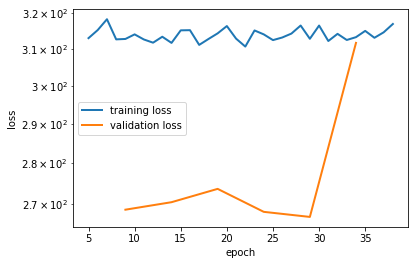

In [19]:
import matplotlib.pyplot as plt

val_len = len(loss_val)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = loss_val[i][0]
  val_plt[1,i] = loss_val[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

# from datetime import datetime
# now=datetime.now()
# timestamp=now.strftime('%Y%d%m%H%M%S')
# path='/content/drive/MyDrive/gnn/dnn_pytorch/gnn_%s.pickle'%(timestamp)
# # torch.save(net.state_dict(),path)
# path='/content/drive/MyDrive/gnn/dnn_pytorch/gnn_118_%s.pickle'%(timestamp)
# torch.save(net.state_dict(),path)
# path = '/content/drive/MyDrive/gnn/dnn_pytorch/gnn_118_20212205071835.pickle'
# net.load_state_dict(torch.load(path))

# Evaluate the model w/ validation set

In [20]:
# local_batch, local_labels = local_batch.to(device), local_labels.to(device)
# print(local_batch.shape)
# x_test_feed = x_test_feed.unsqueeze_(-1).transpose(1,2)
# print(x_test_feed.shape)

# print(local_batch.shape)

In [21]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

n_test = 2000

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed)

Validation dataset size: torch.Size([1583, 6, 1354])
Number of validation set:  2000


* Visualization




 - Visualize errors

In [22]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape)

(1354, 2, 1583)


In [23]:
# recover the original p.u. scale
y_pred1 = y_pred1 / vy_scale + vy_deviation
y_test = y_test / vy_scale + vy_deviation

print(y_test.shape,y_pred1.shape)

(1354, 2, 1583) (1354, 2, 1583)


In [24]:
# for i in range(5):
#   print('sample',i)
#   print(y_test[:,i])
#   print(y_pred1[:,i])

In [25]:
n_test = np.size(y_test,2)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,0,i] - y_pred1[:,0,i]) / np.linalg.norm(y_test[:,0,i])
  err_Linf[i] = np.max(np.abs(y_test[:,0,i] - y_pred1[:,0,i])) / np.max(np.abs(y_test[:,0,i]))

err_L2_v = np.zeros(n_test)
err_Linf_v = np.zeros(n_test)
for i in range(n_test):
  err_L2_v[i] = np.linalg.norm(y_test[:,1,i] - y_pred1[:,1,i]) / np.linalg.norm(y_test[:,1,i])
  err_Linf_v[i] = np.max(np.abs(y_test[:,1,i] - y_pred1[:,1,i])) / np.max(np.abs(y_test[:,1,i]))

In [26]:
print(err_L2.shape,err_Linf.shape)

(1583,) (1583,)


Price L2 mean: 0.06920380935985566 L_inf mean: 0.47581031046839106
Voltage L2 mean: 0.02108207034781623 L_inf mean: 0.12576625437016944


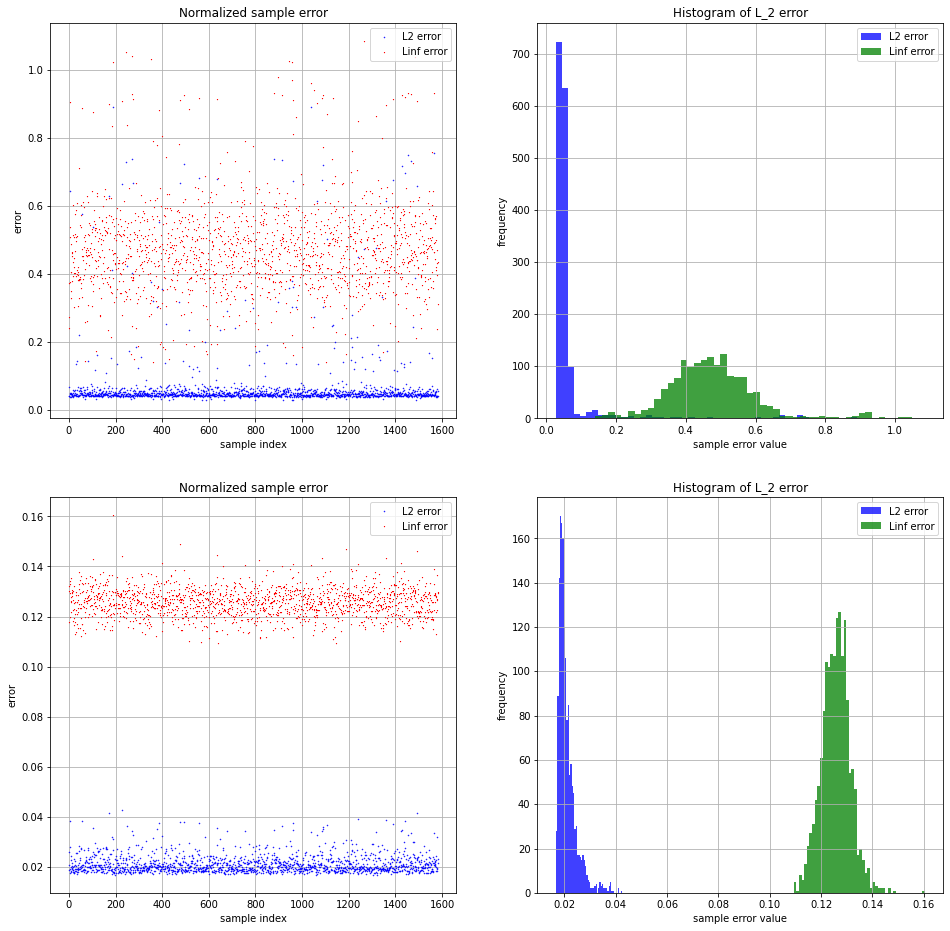

In [27]:
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
err_L2_mean_v = np.mean(err_L2_v)
err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )

fig2 = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(2, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)

plt.subplot(2, 2, 3)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2_v,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf_v,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(2, 2, 4)
plt.hist(err_L2_v, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf_v, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)

plt.show()

(1354, 1583) (1354, 1583)
true range: 1.1343 0.88572
predicted range 1.1350061 0.91326314


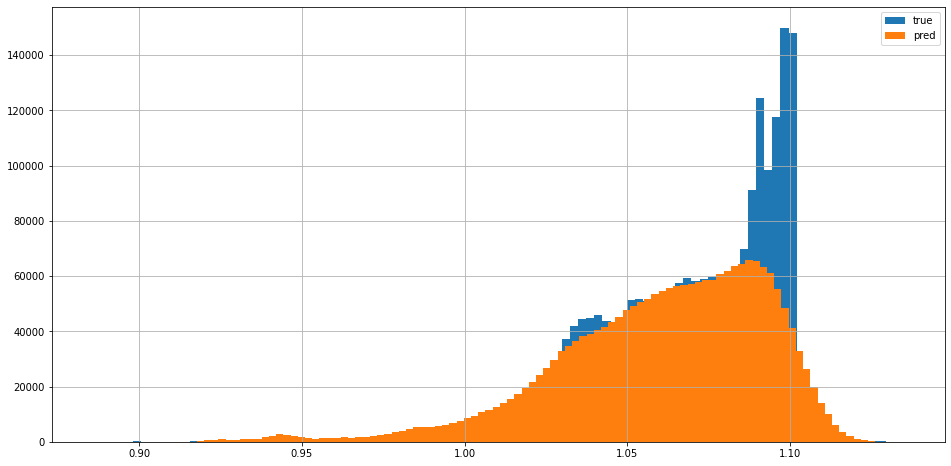

In [28]:
print(y_pred1[:,1,:n_test].shape,y_test[:,1,:n_test].shape)
print('true range:',np.max(y_test[:,1,:n_test]),np.min(y_test[:,1,:n_test]))
print('predicted range',np.max(y_pred1[:,1,:n_test]),np.min(y_pred1[:,1,:n_test]))

fig3 = plt.figure(figsize=(16, 8))
flat_list1 = list(np.concatenate(y_test[:,1,:n_test]).flat)
flat_list2 = list(np.concatenate(y_pred1[:,1,:n_test]).flat)
plt.hist(flat_list1,bins = 100,label = 'true')

plt.hist(flat_list2,bins = 100,label = 'pred')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

1583 L2 mean: 0.06920380935985566 1575 L_inf mean: 0.4729436033847753


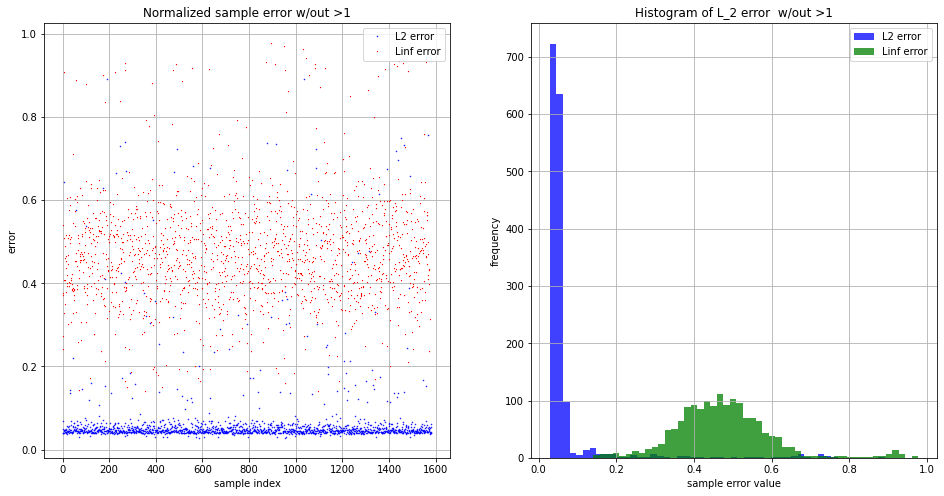

In [29]:
err_l2_new = [i for i in err_L2 if i < 1]
err_linf_new = [i for i in err_Linf if i < 1]
print(len(err_l2_new),'L2 mean:', np.mean(err_l2_new),len(err_linf_new),'L_inf mean:', np.mean(err_linf_new) )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_l2_new,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_linf_new,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error w/out >1')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_l2_new, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error  w/out >1')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [30]:
print(x_train.shape)
# print(x_train[:,:,1].transpose())
# print(np.max(gen_limit0),np.min(err_linf_new))

(1354, 6, 6329)


In [31]:
# y_test_copy
# y_pred1[:,index]

# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [32]:
gen_limit0 = x[:,4,:].copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(1354, 7912)
<class 'numpy.ndarray'> 1354 [   0    1    2 ... 1351 1352 1353]


In [33]:
# # get the generator index
# # generator cost data
# gen_cost0
# # generator limit data
# gen_limit0
# # LMP data
# lmp_data
# # generation data
# gen_data

load_data = x.copy()
load_data = load_data[:,:]
print(load_data.shape)
n_sample = np.size(load_data,2)

# predict the corredponding LMP
x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
batch_size=2000
y_pred1=[]
with torch.no_grad():
  for idx in range(0,x_val_feed.shape[0],batch_size):
    current_batch=x_val_feed[idx:idx+batch_size]
    current_batch=current_batch.to(device)
    current_y=net(current_batch)
    current_y=current_y.cpu().detach()
    current_y=torch.squeeze(current_y,1).numpy().tolist()
    y_pred1+=current_y
y_pred1=np.array(y_pred1).transpose()

print('Dataset size:',x_val_feed.shape)
print('Number of validation points:: ',n_sample)

# net1 = net.cpu()
# y_pred = net1(x_val_feed)

# y_pred1 = y_pred.cpu().detach()
print('output size',y_pred1.shape)
# y_pred1 = torch.squ[]eeze(y_pred1,1).numpy().transpose()
print('reshaped size',y_pred1.shape)

# load_data = x.copy()
# print(load_data.shape)
# n_sample = np.size(load_data,2)

# x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
# x_val_feed = x_val_feed.to(device)

# print('Dataset size:',x_val_feed.shape)
# print('Number of validation points:: ',n_sample)
# y_pred = net(x_val_feed) # predict the corredponding LMP

# y_pred1 = y_pred.cpu().detach()
# print('output size',y_pred1.shape)
# y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
# print('reshaped size',y_pred1.shape)

(1354, 6, 7912)
Dataset size: torch.Size([7912, 6, 1354])
Number of validation points::  7912
output size (1354, 2, 7912)
reshaped size (1354, 2, 7912)


* Save results

In [34]:
import pickle

In [35]:
# dataset = {'lmp_pred': y_pred1, 'lmp_true': lmp_data}
# print('Pred:',y_pred1.shape,'True:',lmp_data.shape)

# file_name = 'dc118_lmp_prediction_p10'
# file_path = 'drive/My Drive/gnn/data/results/'
# file_dir = file_path + file_name + '.pickle'
# outfile = open(file_dir, 'wb')
# pickle.dump(dataset, outfile)
# outfile.close()

In [36]:
gen_cost0 = x[:,4,:].copy()
lmp_data = y[:,0,:].copy()

quadratic_a = x[:,5,:].copy()

profit_pred = y_pred1[:,0,:] - gen_cost0
print(np.min(np.abs(profit_pred)))

profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))

profit_pred=(y_pred1[:,0,:]-gen_cost0)/(quadratic_a+1e-10)/2
profit_true=(lmp_data-gen_cost0)/(quadratic_a+1e-10)/2
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

30.38171197509766
0.0060807
8.373169434491864
0.0038391926724167884


(1354, 7912) (1354, 7912)
0.1409654560653175


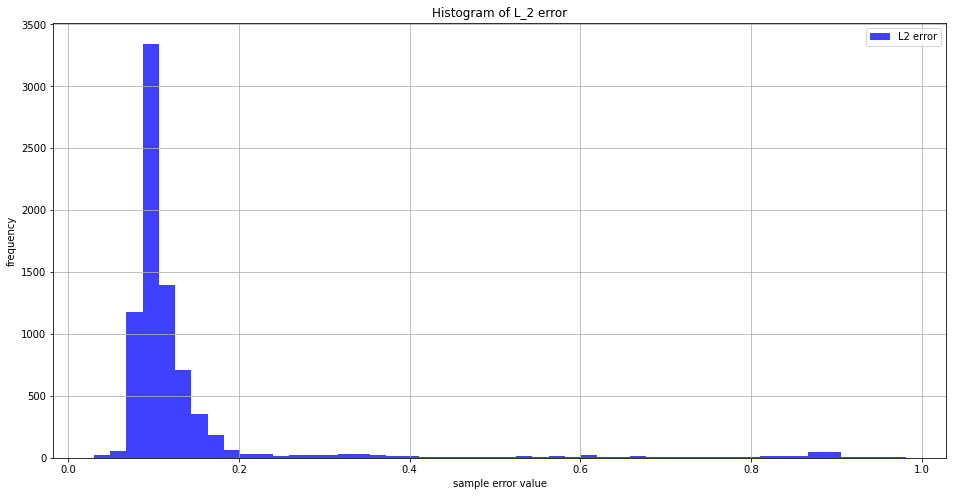

In [37]:
print(profit_pred.shape,profit_true.shape)
profit_err = profit_true - profit_pred

profit_err_l2 = np.zeros([n_sample,1])

for i in range(n_sample):
  profit_err_l2[i] = np.linalg.norm(profit_err[:,i])/np.linalg.norm(profit_true[:,i])
print(np.mean(profit_err_l2))

fig5 = plt.figure(figsize=(16, 8))
# error histogram
plt.hist(profit_err_l2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [38]:
p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)

(10712848,)


In [39]:
print(np.min(p_pred_sort),np.min(p_true_sort))

-341061401367.1875 -262515000000000.0


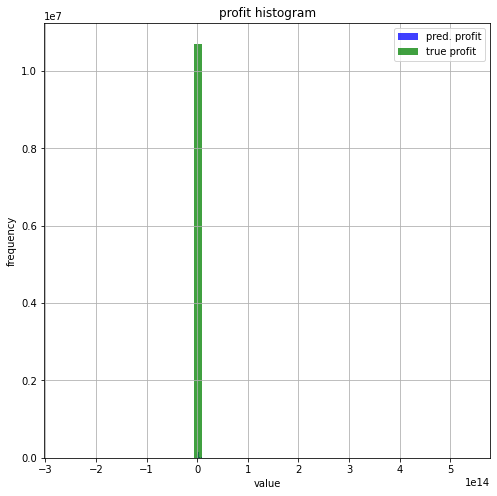

In [40]:
fig2 = plt.figure(figsize=(8, 8))
plt.hist(p_pred_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. profit')
plt.hist(p_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true profit')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('profit histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [41]:
# gen_pred_binary = np.zeros((len(gen_idx),n_sample))
# gen_true_binary = np.zeros((len(gen_idx),n_sample))
# print(gen_pred_binary.shape)

# binary_thres = 2.5
# binary_thres_true = 1e-5

# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres:
#       gen_pred_binary[j,i] = 1
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary[j,i] = 0
#     else:
#       # gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i] + binary_thres) / (2*binary_thres)
#       gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i]) / (binary_thres)
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres_true:
#       gen_true_binary[j,i] = 1
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary[j,i] = 0
#     else:
#       gen_true_binary[j,i] = 0.5

# gen_binary_err = np.abs(gen_true_binary - gen_pred_binary)
# print('max binary error:',np.max(gen_binary_err))
# # count the wrong entries
# gen_binary_err_ct = np.sum(gen_binary_err)
# gen_binary_err_ratio = gen_binary_err_ct / (len(gen_idx)*n_sample)
# print('Binary accuracy:',1-gen_binary_err_ratio)

In [42]:
print(gen_limit0.shape)
print(np.transpose(x_test).shape,np.transpose(load_data).shape)

(1354, 7912)
(1583, 6, 1354) (7912, 6, 1354)


 # Test flow feasibility

In [43]:
x[:,2,:].shape
profit_pred.shape
# n_sample

(1354, 7912)

In [44]:
# x = [load, gen_cost, gen_lim]

# binary_thres = 0.97
binary_thres_true = 1e-5
# binary_thres = gen_limit0
binary_thres = x[:,0,:].copy() # upper
binary_thres_lo = x[:,1,:].copy() # lower

gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))
# print(gen_pred_binary.shape,profit_pred.shape,gen_pred_binary_full.shape)

# x[:,2,:] # p_max

# ## generator injection
# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

## nodal injection
# gen_limit0 = x[:,2,:].copy()
for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]


# injection by generators
# gen_inj = np.multiply(gen_pred_binary_full,gen_limit0)
# gen_inj_true = np.multiply(gen_true_binary_full,gen_limit0)
gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x[:,1,:].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0

In [45]:
# load0 = x[:,0,:].copy()
print(np.sum(p_inj),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

-16961494.3815047 -51982932.679968014
-16961494.3815047 594790649.9596008 -16961494.3815047


## injection accuracy

(1354, 7912) (1354, 7912)
mean p_inj l2 err: 0.16807022939787358


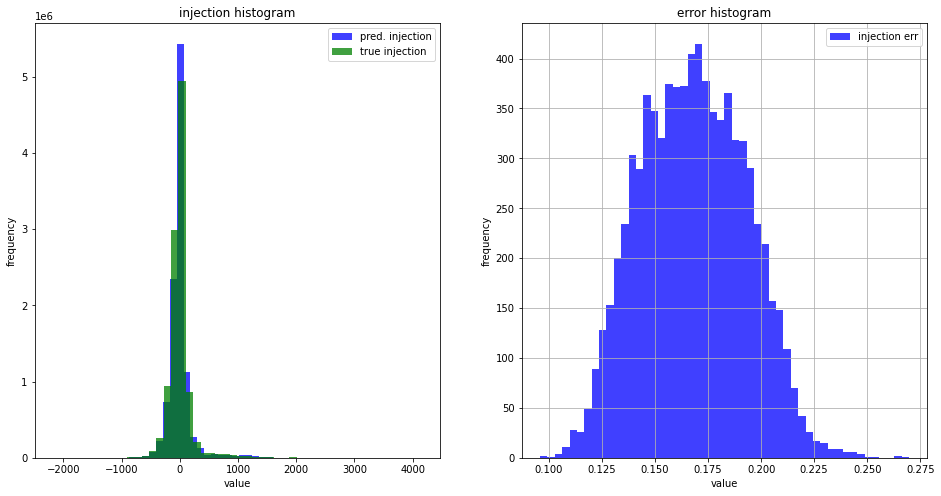

In [46]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
fig3 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('injection histogram')
plt.subplot(1,2,2)
plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('error histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

* Calculate flow

In [47]:
filename=root+'data_1354ac_2022/ieee1354_fmax.txt'
f_max1=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit

n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
# f_max_numpy = f_max.cpu().detach().numpy()
f_max_numpy = f_max1.copy()
f_binary = (np.abs(flow_est)-f_max_numpy > 0)
f_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)

In [48]:
print(f_max_numpy.shape,flow_est.shape,flow_est0.shape)

(1991, 1) (1991, 7912) (1991, 7912)


In [49]:
f_tot_sample = n_line * n_sample
print(np.sum(f_binary),np.sum(f_binary0))
print(np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)

192495 245527
0.01221973857078796 0.01558625290043822


In [50]:
print(n_line,n_sample,flow_est.shape)

1991 7912 (1991, 7912)


In [51]:
# soft threshold
f_err_est = np.abs(flow_est)-f_max_numpy
f_err_true = np.abs(flow_est0)-f_max_numpy

f_err_est = np.maximum(np.abs(flow_est)-f_max_numpy,0) # identify violations
f_err_true = np.maximum(np.abs(flow_est0)-f_max_numpy,0)

print(np.max(f_err_est),np.max(f_err_true))
print(np.max(f_err_est/f_max_numpy),np.max(f_err_true/f_max_numpy))

# a= np.asarray([[1,2,1],[2,2,1]])
# b = np.asarray([1,1,1])
# c = (a-b>0)
# print(c)
# print(np.sum(c))

1017.6398787065064 1357.4447776840975
1.1330394697926736 1.4708429008869848


In [52]:
np.min(f_max_numpy)

281.0

In [53]:
# f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.01*np.max(f_max_numpy))
# f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.01*np.max(f_max_numpy))
f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.1*(f_max_numpy))
f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(f_binary_soft),np.sum(f_binary0_soft))
print(np.sum(f_binary_soft)/f_tot_sample,np.sum(f_binary0_soft)/f_tot_sample)

116957 141985
0.007424525125450777 0.009013322844610656


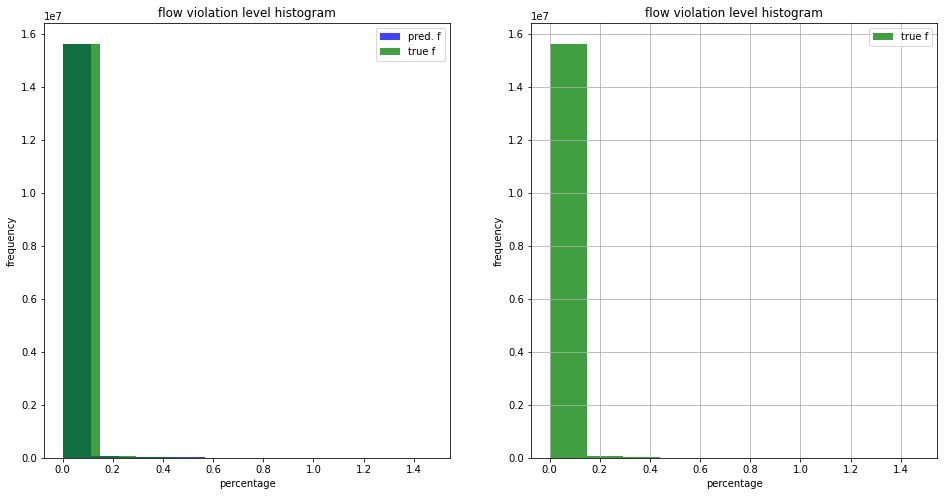

In [54]:
f_pred_sort = np.reshape(f_err_est/f_max_numpy,n_line*n_sample)
f_true_sort = np.reshape(f_err_true/f_max_numpy,n_line*n_sample)

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(f_pred_sort, bins = 10, facecolor='b', alpha=0.75,label = 'pred. f')
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
plt.subplot(1,2,2)
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [55]:
f_line = np.sum(f_binary,0)
f_samp = np.sum(f_binary,1)
print('max sample pred:',np.max(f_line))
print('max line pred:',np.max(f_samp))

f_line0  = np.sum(f_binary0,0)
f_samp0 = np.sum(f_binary0,1)
print('max sample true:',np.max(f_line0))
print('max line true:',np.max(f_samp0))

max sample pred: 46
max line pred: 7912
max sample true: 42
max line true: 7912


# Check objective optimality

In [56]:
# gen_pred_binary_full = np.zeros((n_bus,n_sample))
# gen_true_binary_full = np.zeros((n_bus,n_sample))

# p_inj = gen_inj #- load0
# p_inj_true = gen_inj_true #- load0

# gen_cost0 = x[:,4,:].copy()
# # lmp_data = y.copy()

# quadratic_a = x[:,5,:].copy()
print(gen_cost0.shape)

(1354, 7912)


0.24214681237601582


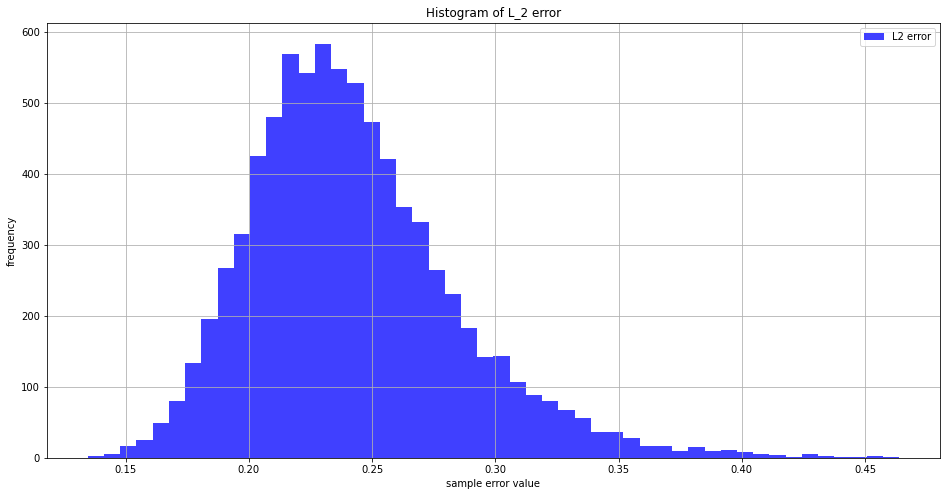

In [57]:
gen_cost_pred = np.zeros((n_bus,n_sample))
gen_cost_true = np.zeros((n_bus,n_sample))
objective_err = np.zeros(n_sample)

gen_cost_pred = np.multiply(np.multiply(p_inj,p_inj),quadratic_a) + np.multiply(p_inj,gen_cost0)
gen_cost_true = np.multiply(np.multiply(p_inj_true,p_inj_true),quadratic_a) + np.multiply(p_inj_true,gen_cost0)

objective_err = np.sum(np.abs(gen_cost_true-gen_cost_pred),axis=0) / np.sum(gen_cost_true,axis=0)
print(np.mean(objective_err))

fig6 = plt.figure(figsize=(16, 8))
# error histogram
plt.hist(objective_err, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [58]:
objective_err.shape

(7912,)

## injection accuracy

(1354, 7912) (1354, 7912)
mean p_inj l2 err: 0.16807022939787358


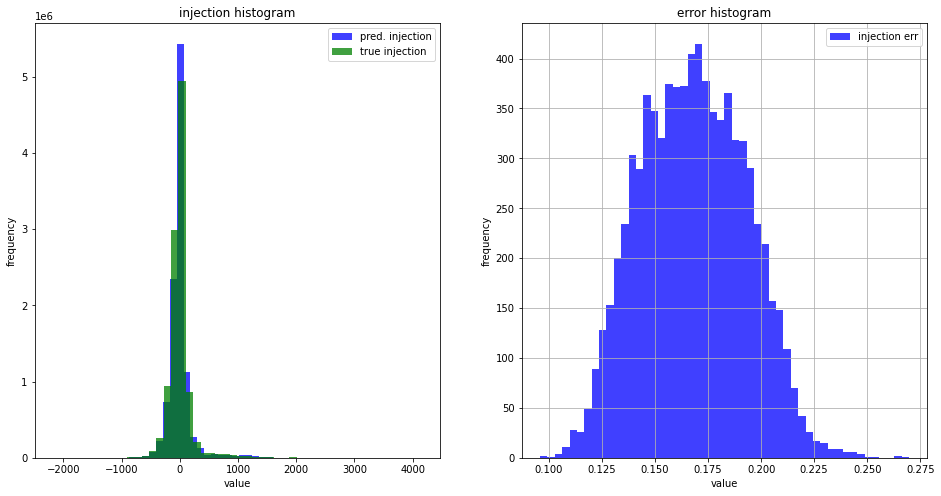

In [59]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
fig3 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('injection histogram')
plt.subplot(1,2,2)
plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('error histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

# Test AC feasibility
* P in actual value, V in p.u.
* Use P to recover $\theta$, or solve $\theta$ and Q for PF
$$ Q_m = V_m \sum_{n=1}^N V_n \left(G_{mn}\sin\theta_{mn} - B_{mn}\cos\theta_{mn} \right) $$
calculate $Q_{mn}$ directly

In [60]:
# p_inj (base all 100), p=B\theta, \theta_r = B_r^-1 p_r, ref bus is 69


In [61]:
# Bbus and B_r inverse
filename1 = root+'data_1354ac_2022/ieee1354_Bbus.txt'
Bbus=pd.read_table(filename1,sep=',',header=None).to_numpy()
B_r = np.delete(Bbus,639,axis=0)
B_r = np.delete(B_r,639,axis=1)

Br_inv = np.linalg.inv(B_r)

# # Y = G + jB
# filename1 = 'data_1354ac_2022/ieee118_Gmat.txt'
# G_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
# filename1 = 'data_1354ac_2022/ieee118_Bmat.txt'
# B_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
# print(G_mat.shape,B_mat.shape)

# line parameters
filename1 = root+'data_1354ac_2022/ieee1354_lineloc.txt'
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()
# line_entry_loc = np.nonzero(G_mat) # index of nonzero entries
# # not in p.u.
# G_line = np.zeros(n_line)
# B_line = np.zeros(n_line)

# # print(line_loc.shape) #[186,2]
# for i in range(n_line):
#   G_line[i] = G_mat[line_loc[i,0]-1,line_loc[i,1]-1]
#   B_line[i] = B_mat[line_loc[i,0]-1,line_loc[i,1]-1]

# load line params
filename1 = root+'data_1354ac_2022/ieee1354_lineparams_tap.txt'
line_params = pd.read_table(filename1,sep=',',header=None).to_numpy()

n_line = 1751 # the rest are transformers
line_loc = line_loc[:n_line,:].copy()
line_params = line_params[:n_line,:].copy()

# filename2 = 'data_1354ac_2022/ieee1354_Ybus.txt'
# Y_bus = pd.read_table(filename2,sep=',',header=None).to_numpy()

# G_line = line_params[:,0].copy()
# B_line = line_params[:,1].copy()
R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()

B_shunt = line_params[:,2].copy()

Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line

G_line = np.real(Y_line)
B_line = np.imag(Y_line)

# P_inj w/out reference bus in p.u.
p_inj_r = np.delete(p_inj,639,axis=0) / 100
p_inj_true_r = np.delete(p_inj_true,639,axis=0) / 100

p_inj_pu = p_inj / 100
p_inj_true_pu = p_inj_true / 100

print(Br_inv.shape,p_inj.shape,p_inj_true.shape)#p_inj_true

# calculate angle (w/our reference at 640th node)
theta0 = np.matmul(Br_inv,p_inj_r)
theta_true0 = np.matmul(Br_inv,p_inj_true_r)

theta = np.insert(theta0,639,0,axis = 0)
theta_true = np.insert(theta_true0,639,0,axis = 0)

# filename1 = '/content/drive/MyDrive/gnn/data/data_118_quad/ieee118_ac_10000_theta.txt'
# theta = pd.read_table(filename1,sep=',',header=None).to_numpy()
# theta = theta / 180 * math.pi

print(theta.shape,theta_true.shape)

(1353, 1353) (1354, 7912) (1354, 7912)
(1354, 7912) (1354, 7912)


In [62]:
for i in range(5):
  print(G_line[i],B_line[i])

280.2162646860566 -1215.8272373322789
10.305452749392991 -58.08781033008072
29.51096121416526 -227.65598650927487
32.83209665769257 -403.8347888896185
20.97476735487209 -263.58290975955924


In [63]:
print(np.max(theta),np.min(theta))
# math.sin(math.pi/6)
print(G_line[0],B_line[0])


# print(Y_bus.shape,line_loc.shape,G_line.shape,n_line)

# G_line1 = np.zeros(n_line)
# B_line1 = np.zeros(n_line)

# for i in range(2):
#   Y_temp = Y_bus[line_loc[i,0]-1,line_loc[i,1]-1]
#   Y_temp = Y_temp.replace('i','j')
#   Y_temp = complex(Y_temp)
#   # print(type(Y_temp))
#   # print(Y_temp,np.real(Y_temp),np.imag(Y_temp))
#   G_line1[i] = np.real(Y_temp)
#   B_line1[i] = np.imag(Y_temp)

# G_line = G_line1
# B_line = B_line1

0.5925677163357742 -1.8002321881617682
280.2162646860566 -1215.8272373322789


In [64]:
print(type(G_line))
print(np.max(y_pred1[:,1,:]),np.min(y_pred1[:,1,:]))
print(np.max(theta),np.min(theta))
print(math.sin(math.pi/6))

<class 'numpy.ndarray'>
337.9424743652344 112.97512817382812
0.5925677163357742 -1.8002321881617682
0.49999999999999994


In [65]:
# B_line
import math

# n_sample1 = 500
n_sample1 = n_sample
f_tot_sample1 = n_line*n_sample1

# load true voltage file
filename1 = root+'data_1354ac_2022/ieee1354_v.txt'
v_true = pd.read_table(filename1,sep=',',header=None).to_numpy()
print(v_true.shape)

# load true theta file
filename2 = root+'data_1354ac_2022/ieee1354_ieee1354_theta1.txt'
theta_true = pd.read_table(filename2,sep=',',header=None).to_numpy()
# theta_true = theta_true / 180 * math.pi
print(theta_true)
print(theta_true.shape)

(1354, 7912)
[[-0.33946158 -0.36191947 -0.30172529 ... -0.28151791 -0.31030403
  -0.30083899]
 [-0.02805205 -0.03617815 -0.02332209 ... -0.01011947 -0.01874209
  -0.04354166]
 [-0.77350134 -0.76624256 -0.76011433 ... -0.77338365 -0.7563987
  -0.77607445]
 ...
 [-0.56132425 -0.44577874 -0.44534729 ... -0.47747146 -0.46650477
  -0.53119228]
 [-0.63013197 -0.60753905 -0.60806015 ... -0.61657531 -0.61827364
  -0.6161674 ]
 [-0.45894729 -0.5025309  -0.49359456 ... -0.4918437  -0.4868828
  -0.50169019]]
(1354, 7912)


In [66]:
# transformer indicator
# a = R_line > 0
a = np.ones(n_line)

# Calculate real and reactive flow
f_p = np.zeros((n_line,n_sample1))
f_q = np.zeros((n_line,n_sample1))
fji_p = np.zeros((n_line,n_sample1))
fji_q = np.zeros((n_line,n_sample1))
print(f_q.shape)

v_pred = y_pred1[:,1,:].copy()
v_pred = v_pred / vy_scale + vy_deviation

# v_pred = v_true.copy()
# theta = theta_true.copy()

print(np.max(v_pred),np.min(v_pred),v_pred.shape)

theta1 = theta[line_loc[:,0]-1,:]
theta2 = theta[line_loc[:,1]-1,:]
V1 = torch.from_numpy(v_pred[line_loc[:,0]-1,:]).double()
V2 = torch.from_numpy(v_pred[line_loc[:,1]-1,:]).double() 
a=torch.from_numpy(a)
G_line=torch.from_numpy(G_line)
B_line=torch.from_numpy(B_line)
B_shunt=torch.from_numpy(B_shunt)
theta1=torch.from_numpy(theta1)
theta2=torch.from_numpy(theta2)

f_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*torch.cos(theta1-theta2).T+B_line*torch.sin(theta1-theta2).T)
f_p=f_p.T
f_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*torch.cos(theta1-theta2).T-G_line*torch.sin(theta1-theta2).T)
f_q=f_q.T

theta1 = theta[line_loc[:,1]-1,:]
theta2 = theta[line_loc[:,0]-1,:]
V1 = torch.from_numpy(v_pred[line_loc[:,1]-1,:]).double()
V2 = torch.from_numpy(v_pred[line_loc[:,0]-1,:]).double()
theta1=torch.from_numpy(theta1)
theta2=torch.from_numpy(theta2)

fji_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*torch.cos(theta1-theta2).T+B_line*torch.sin(theta1-theta2).T)
fji_p=fji_p.T
fji_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*torch.cos(theta1-theta2).T-G_line*torch.sin(theta1-theta2).T)
fji_q=fji_q.T

# for i in range(n_line):
#   for j in range(n_sample1):
#     f_p[i,j] = a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,0]-1,j] * G_line[i] \
#              - (a[i] * v_pred[line_loc[i,0]-1,j]) * v_pred[line_loc[i,1]-1,j] \
#              * (G_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
#               + B_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
#     f_q[i,j] =-(a[i] * v_pred[line_loc[i,0]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
#              + a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,1]-1,j] \
#              * (B_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
#               - G_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
#     fji_p[i,j] = a[i] * v_pred[line_loc[i,1]-1,j] * v_pred[line_loc[i,1]-1,j] * G_line[i] \
#              - (a[i] * v_pred[line_loc[i,1]-1,j]) * v_pred[line_loc[i,0]-1,j] \
#              * (G_line[i] * math.cos(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]) \
#               + B_line[i] * math.sin(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]))
#     fji_q[i,j] =-(a[i] * v_pred[line_loc[i,1]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
#              + a[i] * v_pred[line_loc[i,1]-1,j] * v_pred[line_loc[i,0]-1,j] \
#              * (B_line[i] * math.cos(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]) \
#               - G_line[i] * math.sin(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]))         


(1751, 7912)
1.1379424743652344 0.9129751281738282 (1354, 7912)


In [67]:
print('mean p_ij,q_ij:',torch.mean(f_p),torch.mean(f_q))
print('mean p_ji,q_ji:',torch.mean(fji_p),torch.mean(fji_q))
# print(f_q)

mean p_ij,q_ij: tensor(0.1178, dtype=torch.float64) tensor(0.4998, dtype=torch.float64)
mean p_ji,q_ji: tensor(-0.0840, dtype=torch.float64) tensor(-0.2804, dtype=torch.float64)


In [68]:
# theta = theta_true.copy()
print('Scale check:')
i=0;j=0
# a[0] = 1
a = np.ones(1751)
print('G,B,loc:',G_line[i],B_line[i],line_loc[i,0]-1,line_loc[i,1]-1) # G,B,line_loc verified
print('v:',v_pred[line_loc[i,0]-1,j],v_pred[line_loc[i,1]-1,j]) # v verified
print('theta:',theta[line_loc[i,0]-1,j],theta[line_loc[i,1]-1,j]) # theta verified
print('p,q:',f_p[0,0],f_q[0,0],fji_p[i,j],fji_q[i,j])


f_p_test = a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,0]-1,j] * G_line[i] \
             - (a[i] * v_pred[line_loc[i,0]-1,j]) * v_pred[line_loc[i,1]-1,j] \
             * (G_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              + B_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
f_q_test =-(a[i] * v_pred[line_loc[i,0]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
             + a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,1]-1,j] \
             * (B_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              - G_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
print('test p/q:',f_p_test,f_q_test)

Scale check:
G,B,loc: tensor(280.2163, dtype=torch.float64) tensor(-1215.8272, dtype=torch.float64) 1073 801
v: 1.085679443359375 1.086232177734375
theta: -0.38663004122704114 -0.3862179746853352
p,q: tensor(-0.7590, dtype=torch.float64) tensor(-0.5933, dtype=torch.float64) tensor(0.7591, dtype=torch.float64) tensor(0.5939, dtype=torch.float64)
test p/q: tensor(-0.7590, dtype=torch.float64) tensor(-0.5933, dtype=torch.float64)


In [69]:
print(a[i],v_pred[line_loc[i,0]-1,j],B_line[i] + B_shunt[i]/2,v_pred[line_loc[i,1]-1,j])
print(G_line[i],math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]),math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))

1.0 1.085679443359375 tensor(-1215.8272, dtype=torch.float64) 1.086232177734375
tensor(280.2163, dtype=torch.float64) 0.9999999151005838 -0.00041206653004454357


In [70]:
# Calculate apparent power
# s_pred = np.zeros((n_line,n_sample1))
# sji_pred = np.zeros((n_line,n_sample1))

# for i in range(n_line):
#   for j in range(n_sample1):
#     # s_pred[i,j] = np.sqrt(flow_est[i,j]**2 + f_q[i,j]**2)
#     s_pred[i,j] = np.sqrt(f_p[i,j]**2 + f_q[i,j]**2)
#     sji_pred[i,j] = np.sqrt(fji_p[i,j]**2 + fji_q[i,j]**2)

s_pred = torch.sqrt(f_p*f_p+f_q*f_q)*100
sji_pred = torch.sqrt(fji_p*fji_p+fji_q*fji_q)*100
# s_pred = s_pred * 100 # p.u. to mva
# sji_pred = sji_pred * 100 # p.u. to mva

In [71]:
# np.max(y_pred1[:,1,:]/100+0.8)

f_p = f_p.numpy();f_q = f_q.numpy()
s_pred = s_pred.numpy();sji_pred = sji_pred.numpy()

print(np.max(f_q),np.min(f_q))
flow_est.shape

print(np.mean(s_pred[0,:]),np.mean(f_max_numpy[0]))

154.00338792537514 -253.23274846884215
129.0818888326369 39412.0


In [72]:
sij_binary = (np.abs(s_pred)-f_max_numpy[:n_line] > 0)
sji_binary = (np.abs(sji_pred)-f_max_numpy[:n_line] > 0)
s_binary = np.maximum(sij_binary,sji_binary)

# sij_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)
print(np.sum(s_binary))#,np.sum(f_binary0))
print('hard violation rate:',np.sum(s_binary)/f_tot_sample1)#,np.sum(f_binary0)/f_tot_sample)

s_binary_soft = (np.abs(s_pred)-f_max_numpy[:n_line] > 0.1*(f_max_numpy[:n_line]))
# s_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(s_binary_soft))#,np.sum(f_binary0_soft))
print(np.sum(s_binary_soft)/f_tot_sample1)#,np.sum(f_binary0_soft)/f_tot_sample)

825897
hard violation rate: 0.05961471388009394
656426
0.047381995785739074


S violation level:
hard: 0.05961471388009394
mean: 0.1716711592098544
median: 0.0
max: 41.78381747032516
std: 1.478043672177848
p99: 5.350790199459352
f violation level:
hard: 0.01221973857078796 0.01558625290043822
mean: 0.002319211675763134
median: 0.0
max: 1.1330394697926736
std: 0.027906071892402056
p99: 0.03815119017464791


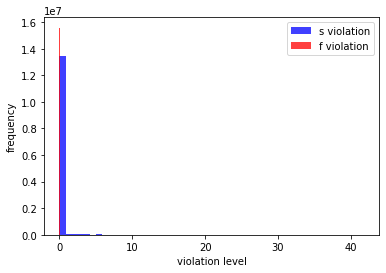

In [73]:
# violation level
sij_violation = np.abs(s_pred)-f_max_numpy[:n_line] #/ f_max_numpy
sij_violation_level = np.maximum(sij_violation,0)
sji_violation = np.abs(sji_pred)-f_max_numpy[:n_line] #/ f_max_numpy
sji_violation_level = np.maximum(sji_violation,0)

s_violation_level = np.maximum(sij_violation_level,sji_violation_level)

s_violation_level = np.divide(s_violation_level,f_max_numpy[:n_line])
s_vio_lvl = np.reshape(s_violation_level,n_line*n_sample1)

print('S violation level:')
print('hard:',np.sum(s_binary)/f_tot_sample1)
print('mean:',np.mean(s_vio_lvl))
print('median:',np.median(s_vio_lvl))
print('max:',np.max(s_vio_lvl))
print('std:',np.std(s_vio_lvl))
print('p99:',np.percentile(s_vio_lvl,99))

f_violation = np.abs(flow_est)-f_max_numpy #/ f_max_numpy
f_violation_level = np.maximum(f_violation,0)
f_violation_level = np.divide(f_violation_level,f_max_numpy)
f_vio_lvl = np.reshape(f_violation_level,1991*n_sample)

print('f violation level:')
print('hard:',np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)
print('mean:',np.mean(f_vio_lvl))
print('median:',np.median(f_vio_lvl))
print('max:',np.max(f_vio_lvl))
print('std:',np.std(f_vio_lvl))
print('p99:',np.percentile(f_vio_lvl,99))

fig4 = plt.figure(figsize=(6,4))
plt.hist(s_vio_lvl, bins = 50, facecolor='b', alpha=0.75,label = 's violation')
plt.hist(f_vio_lvl, bins = 50, facecolor='r', alpha=0.75,label = 'f violation')
plt.legend(loc="upper right")
plt.xlabel('violation level')
plt.ylabel('frequency')
# plt.title('injection histogram')
plt.show()

In [74]:
# err_L2_mean = np.mean(err_L2)
# err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
print('std:',np.std(err_L2))
# err_L2_mean_v = np.mean(err_L2_v)
# err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )
print('std:',np.std(err_L2_v))

Price L2 mean: 0.06920380935985566 L_inf mean: 0.47581031046839106
std: 0.09751771729093119
Voltage L2 mean: 0.02108207034781623 L_inf mean: 0.12576625437016944
std: 0.003647341393548623


In [ ]:
# np.max(s_violation_level)
# s_violation_level[:,0]
# print(s_pred[:,0])
# print(f_max_numpy)

In [ ]:
# # solve for Q
# from scipy.optimize import fsolve

# # print(np.max(theta*180/2/math.pi),np.max(theta_true*180/2/math.pi))

# def PF_eq(Q,V,G_mat,B_mat,n_bus,line_loc):
#   PF_obj = [None]*n_bus
#   for i in range(n_bus):
#     PF_obj[i] = 

#   return PF_obj

# line_loc = np.nonzero(G_mat) # index of nonzero entries
# root = fsolve(PF_eq, np.zeros(118, args=(y_pred1[:,1,:0],G_mat,B_mat,n_bus,line_loc))